In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🎬 Netflix Prize Dataset – Deep Data Exploration

In this notebook we will:
- Parse the Netflix Prize dataset into a clean table
- Explore **user behavior** and **movie behavior** in depth
- Reveal hidden patterns that influence how we build a recommender model
- Explain why each exploration matters for later model development

By the end, you’ll understand:
- The shape and sparsity of the rating matrix
- How active different users are
- How popular movies are distributed
- How time (date of rating) might affect models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')


In [3]:
ratings_file = "/kaggle/input/netflix-prize-data/combined_data_1.txt"
movies_file = "/kaggle/input/netflix-prize-data/movie_titles.csv"

# Read raw lines as text (handles mixed format safely)
with open(ratings_file, 'r') as f:
    raw_lines = f.readlines()

# Wrap into a DataFrame to keep the for-loop logic the same
ratings_raw = pd.DataFrame(raw_lines, columns=['Raw'])
ratings_raw.head(10)


,Raw
0,1:\n
1,"1488844,3,2005-09-06\n"
2,"822109,5,2005-05-13\n"
3,"885013,4,2005-10-19\n"
4,"30878,4,2005-12-26\n"
5,"823519,3,2004-05-03\n"
6,"893988,3,2005-11-17\n"
7,"124105,4,2004-08-05\n"
8,"1248029,3,2004-04-22\n"
9,"1842128,4,2004-05-09\n"


In [4]:
movie_id = None
data = []
for row in ratings_raw['Raw']:
    row = row.strip()
    if row.endswith(':'):
        movie_id = int(row[:-1])
    else:
        parts = row.split(',')
        data.append([int(parts[0]), movie_id, int(parts[1]), parts[2]])

ratings_df = pd.DataFrame(data, columns=['UserID','MovieID','Rating','Date'])
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])
ratings_df.head()


,UserID,MovieID,Rating,Date
0,1488844,1,3,2005-09-06
1,822109,1,5,2005-05-13
2,885013,1,4,2005-10-19
3,30878,1,4,2005-12-26
4,823519,1,3,2004-05-03


In [6]:
movie_id = None
data = []

for row in ratings_raw['Raw']:
    row = row.strip()  # remove whitespace and newline
    if row.endswith(':'):  # movie id line
        movie_id = int(row[:-1])  # remove colon and convert to int
    elif row:  # skip empty lines
        parts = row.split(',')
        if len(parts) == 3:  # valid rating line
            try:
                user_id = int(parts[0])
                rating = int(parts[1])
                date = parts[2]
                data.append([user_id, movie_id, rating, date])
            except ValueError:
                continue  # skip malformed line

ratings_df = pd.DataFrame(data, columns=['UserID','MovieID','Rating','Date'])
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])
ratings_df.head()


,UserID,MovieID,Rating,Date
0,1488844,1,3,2005-09-06
1,822109,1,5,2005-05-13
2,885013,1,4,2005-10-19
3,30878,1,4,2005-12-26
4,823519,1,3,2004-05-03


In [8]:
movies_df = pd.read_csv(
    movies_file,
    header=None,
    names=['MovieID', 'Year', 'Title'],
    encoding='ISO-8859-1',
    engine='python',     # more robust parser
    quotechar='"',       # handle commas inside titles
    on_bad_lines='skip'  # skip any truly malformed rows
)

print(f"Movies loaded: {len(movies_df)}")
movies_df.head()


Movies loaded: 17434


,MovieID,Year,Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [9]:
df = ratings_df.merge(movies_df, on='MovieID', how='left')
print("Merged dataset shape:", df.shape)
df.head()


Merged dataset shape: (24053764, 6)


,UserID,MovieID,Rating,Date,Year,Title
0,1488844,1,3,2005-09-06,2003.0,Dinosaur Planet
1,822109,1,5,2005-05-13,2003.0,Dinosaur Planet
2,885013,1,4,2005-10-19,2003.0,Dinosaur Planet
3,30878,1,4,2005-12-26,2003.0,Dinosaur Planet
4,823519,1,3,2004-05-03,2003.0,Dinosaur Planet


In [10]:
print("Number of ratings:", len(df))
print("Unique users:", df['UserID'].nunique())
print("Unique movies:", df['MovieID'].nunique())

df.info()

Number of ratings: 24053764
Unique users: 470758
Unique movies: 4499
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24053764 entries, 0 to 24053763
Data columns (total 6 columns):
 #   Column   Dtype         
---  ------   -----         
 0   UserID   int64         
 1   MovieID  int64         
 2   Rating   int64         
 3   Date     datetime64[ns]
 4   Year     float64       
 5   Title    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.1+ GB


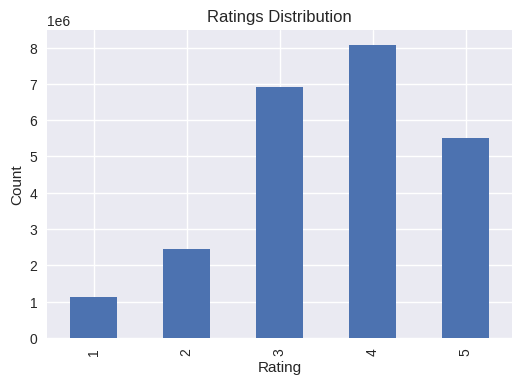

In [14]:
rating_counts = df['Rating'].value_counts().sort_index()

rating_counts.plot(kind='bar', figsize=(6,4))
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


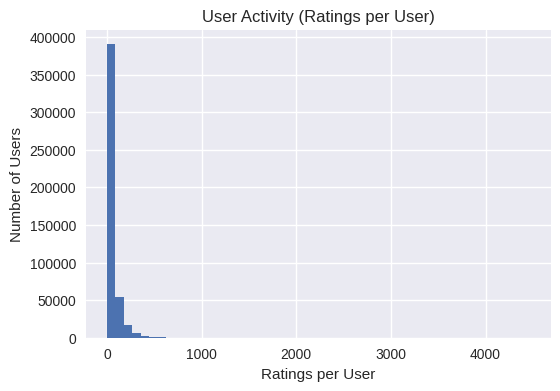

Median ratings per user: 24.0
Users with >500 ratings: 1094


In [12]:
user_activity = df['UserID'].value_counts()

user_activity.hist(bins=50, figsize=(6,4))
plt.title('User Activity (Ratings per User)')
plt.xlabel('Ratings per User')
plt.ylabel('Number of Users')
plt.show()

print("Median ratings per user:", user_activity.median())
print("Users with >500 ratings:", (user_activity > 500).sum())


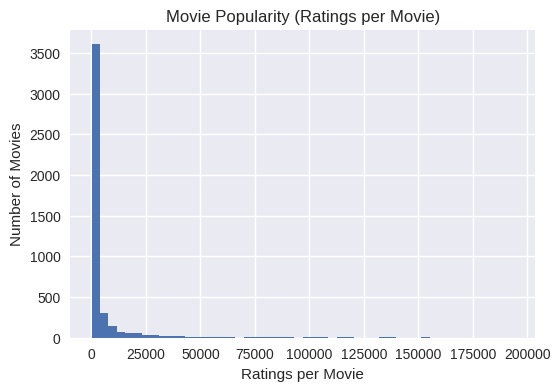

Median ratings per movie: 552.0


In [15]:
movie_popularity = df['MovieID'].value_counts()

movie_popularity.hist(bins=50, figsize=(6,4))
plt.title('Movie Popularity (Ratings per Movie)')
plt.xlabel('Ratings per Movie')
plt.ylabel('Number of Movies')
plt.show()

print("Median ratings per movie:", movie_popularity.median())


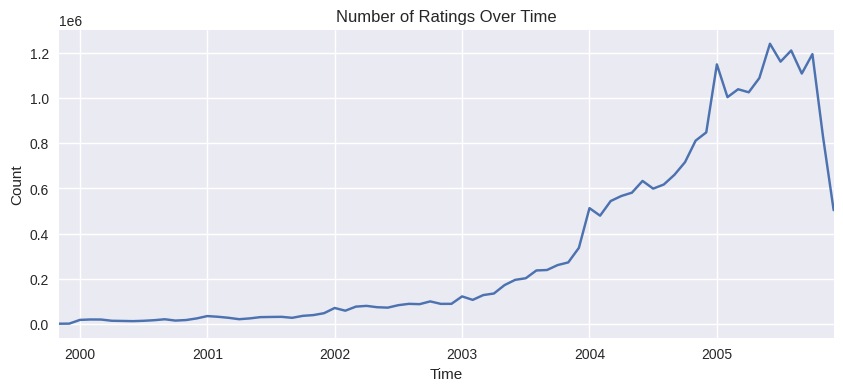

In [16]:
df['YearMonth'] = df['Date'].dt.to_period('M')
ratings_over_time = df.groupby('YearMonth').size()

ratings_over_time.plot(figsize=(10,4))
plt.title('Number of Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()


In [17]:
num_users = df['UserID'].nunique()
num_movies = df['MovieID'].nunique()
matrix_size = num_users * num_movies
num_ratings = len(df)
sparsity = 1 - (num_ratings / matrix_size)

print(f"Matrix size: {matrix_size:,}")
print(f"Number of ratings: {num_ratings:,}")
print(f"Sparsity: {sparsity:.4f}")


Matrix size: 2,117,940,242
Number of ratings: 24,053,764
Sparsity: 0.9886


In [18]:
cold_movies = (movie_popularity < 10).sum()
print("Movies with <10 ratings:", cold_movies)

cold_users = (user_activity < 10).sum()
print("Users with <10 ratings:", cold_users)


Movies with <10 ratings: 0
Users with <10 ratings: 129803


## ✅ Key Insights from Exploratory Data Analysis

- **Sparsity**: Most user–movie cells are empty, so a sparse matrix approach is needed.
- **User Activity**: A few power users, many casual. We might weight or filter accordingly.
- **Movie Popularity**: Many movies have very few ratings → cold-start problem.
- **Rating Distribution**: Slight skew toward higher ratings. Normalization may help.
- **Time Trends**: Ratings volume changes over time.
- **Cold Start**: Hybrid or popularity-based models needed for new items/users.

These insights directly inform which recommendation approach to use:
- Baseline popularity model for cold-start.
- Collaborative filtering for active users/items.
- Matrix factorization to handle sparsity.
- Time-aware or hybrid models for evolving data.
